In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import numpy as np

import py21cmfast as p21c
from astropy.cosmology import Planck18
from scipy import interpolate

sys.path.append("..")
from dm21cm.dm_params import DMParams
from dm21cm.evolve import evolve
import dm21cm.physics as phys

sys.path.append(os.environ['DH_DIR'])
from darkhistory.main import evolve as evolve_DH

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


## DMParam

In [2]:
dm_params = DMParams(
    mode = 'decay',
    primary = 'elec_delta',
    m_DM = 1e8,
    lifetime = 1e25,
)

tf_version = 'zf01'

In [2]:
dm_params = DMParams(
    mode = 'decay',
    primary = 'phot_delta',
    m_DM = 1.2e10,
    lifetime = 1e50,
)

tf_version = 'zf01'

## DarkHistory

In [3]:
from darkhistory.config import load_data
load_data('dep_tf', prefix=f'/n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1_{tf_version}')
load_data('ics_tf', prefix=f'/n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1_{tf_version}');

****** Loading transfer functions... ******
Using data at /n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1_zf01
    for propagating photons...  

 Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


In [12]:
run_name = 'dhc_test'

soln = evolve_DH(
    DM_process=dm_params.mode, mDM=dm_params.m_DM,
    primary=dm_params.primary,
    sigmav=dm_params.sigmav, lifetime=dm_params.lifetime,
    struct_boost=dm_params.struct_boost,
    start_rs=3000, end_rs=4.+1, coarsen_factor=12, verbose=1,
    # use fake reionization to get case-A recomb. coeff.
    reion_switch=True, reion_rs=47.,
    photoion_rate_func=[lambda x: 0., lambda x: 0., lambda x: 0.],
    photoheat_rate_func=[lambda x: 0., lambda x: 0., lambda x: 0.],
    cross_check_21cmfast=True,
    cross_check_21cmfast_tf_version=tf_version,
    debug_no_bath=False,
)

pickle.dump(soln, open(f"run_info/{run_name}_dh_soln.p", 'wb'))

Loading time: 0.003 s


  0%|          | 0/534 [00:00<?, ?it/s]WARNING:root:Cross checking 21cmfast!


Initialization time: 0.184 s


 64%|██████▍   | 344/534 [01:39<00:55,  3.42it/s]WARNING:root:Setting coarsen_factor=1!
573it [02:22,  4.03it/s]                         


Main loop time: 142.120 s


In [13]:
run_name = 'dhc_test'
dh_soln = pickle.load(open(f"run_info/{run_name}_dh_soln.p", 'rb'))
dh_xe_interp_func = lambda z: interpolate.interp1d(dh_soln['rs']-1, dh_soln['x'][:, 0])(z).item()
hep_N_arr = np.array([s.N for s in dh_soln['highengphot']])
hep_rs_arr = np.array([s.rs for s in dh_soln['highengphot']])
dh_bath_N_interp_func = interpolate.interp1d(hep_rs_arr-1, hep_N_arr, axis=0)

In [14]:
! mkdir $P21C_CACHE_DIR/dhc_test
! cp -v run_info/dhc_test_dh_soln.p $P21C_CACHE_DIR/dhc_test/dh_init_soln.p

mkdir: cannot create directory ‘/n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/dhc_test’: File exists


'run_info/dhc_test_dh_soln.p' -> '/n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/dhc_test/dh_init_soln.p'


In [ ]:
return_dict = evolve(
    run_name = 'dhc_test',
    z_start = 45.,
    z_end = 5.,
    zplusone_step_factor = 1.01,
    dm_params = dm_params,
    enable_elec = True,
    tf_version = tf_version,
    
    p21c_initial_conditions = p21c.initial_conditions(
        user_params = p21c.UserParams(
            HII_DIM = 16,
            BOX_LEN = 16 * 4, # [conformal Mpc]
            N_THREADS = 32,
        ),
        cosmo_params = p21c.CosmoParams(
            OMm = Planck18.Om0,
            OMb = Planck18.Ob0,
            POWER_INDEX = Planck18.meta['n'],
            #SIGMA_8 = Planck18.meta['sigma8'],
            SIGMA_8 = 1e-8,
            hlittle = Planck18.h,
        ),
        random_seed = 54321,
        write = True,
    ),
    
    rerun_DH = False,
    clear_cache = True,
    use_tqdm = False,
    debug_flags = [],
    debug_xray_multiplier = 1.,
    debug_astro_params = p21c.AstroParams(
        L_X = 0. # log10 value
    ),
    save_dir='run_info',
    custom_YHe = 0.245,
    #debug_dhc_delta_fixed=True,
    #debug_dhc_DH_xe_func=dh_xe_interp_func,
    #dh_bath_N_interp_func=dh_bath_N_interp_func,
    track_Tk_xe=True,
    track_Tk_xe_set_tf_input=False,
)

(<Figure size 720x480 with 1 Axes>,
 <Axes: xlabel='Iteration', ylabel='Time [s]'>)

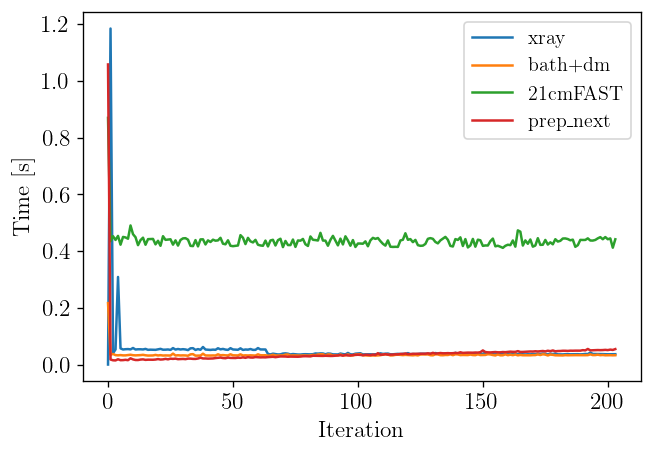

In [9]:
return_dict['profiler'].plot()

## compare

In [10]:
def plot_global(dh_soln, soln, tracker=False):
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    color_dict = {
        'DH' : 'k',
        '21' : 'r',
    }

    z_plot_start = 50.
    i_z_st = np.argmin(np.abs(dh_soln['rs']-1 - z_plot_start))
    ax = axs[0,0]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['Tm'][i_z_st:]/phys.kB, color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['T_k'], color=color_dict['21'], ls=':', label='dm21cm')
    if tracker:
        ax.plot(soln['z'], soln['T_k_tracker'], color='b', ls='--', label='tracker')
    ax.plot(soln['z'][0], soln['T_k'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$T_k$ [K]', title='Gas temperature')
    ax.legend()

    ax = axs[0,1]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 0], color=color_dict['DH'], label='DH HII')
    #ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 1], color='b', label='DH HeII')
    ax.plot(soln['z'], soln['x_e'], color=color_dict['21'], ls=':', label='dm21cm')
    if tracker:
        ax.plot(soln['z'], soln['x_e_tracker'], color='b', ls='--', label='tracker')
    ax.plot(soln['z'][0], soln['x_e'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$x_e$', title='$x_e$')
    ax.legend()

    ax = axs[0,2]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 0], color=color_dict['DH'], label='DH HII')
    #ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 1], color='b', label='DH HeII')
    ax.plot(soln['z'], soln['1-x_H'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['1-x_H'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$1-x_H$', title='$1-x_H$')
    ax.legend()

    ax = axs[0,3]
    ax.plot(soln['z'], soln['T_b'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log')
    ax.set(xlabel='$z$', ylabel='$T_b$ [K]', title='Brightness temperature')

    ax = axs[1,0]
    dh_bath_engs = [s.toteng() for s in dh_soln['highengphot']]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_bath_engs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['E_phot'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['E_phot'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$E$ [eV/Bavg]', title='Bath energy')

    ax = axs[1,1]
    dh_fs = dh_soln['f']['low']['heat'] + dh_soln['f']['high']['heat']
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_fs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['dep_heat']/soln['dE_inj_per_Bavg_unclustered'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$f$', title=r'$f\mathrm{heat}$')

    ax = axs[1,2]
    dh_fs = dh_soln['f']['low']['H ion'] + dh_soln['f']['high']['H ion'] + dh_soln['f']['low']['He ion'] + dh_soln['f']['high']['He ion']
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_fs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['dep_ion']/soln['dE_inj_per_Bavg_unclustered'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$f$', title=r'$f\mathrm{ion}$')

    ax = axs[1,3]
    dh_fs = dh_soln['f']['low']['exc'] + dh_soln['f']['high']['exc']
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_fs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['dep_exc']/soln['dE_inj_per_Bavg_unclustered'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$f$', title=r'$f\mathrm{exc}$')

/tmp/ipykernel_213550/2960396429.py:57: RuntimeWarning: invalid value encountered in divide
  ax.plot(soln['z'], soln['dep_heat']/soln['dE_inj_per_Bavg_unclustered'], color=color_dict['21'], ls=':', label='dm21cm')
/tmp/ipykernel_213550/2960396429.py:64: RuntimeWarning: invalid value encountered in divide
  ax.plot(soln['z'], soln['dep_ion']/soln['dE_inj_per_Bavg_unclustered'], color=color_dict['21'], ls=':', label='dm21cm')
/tmp/ipykernel_213550/2960396429.py:71: RuntimeWarning: invalid value encountered in divide
  ax.plot(soln['z'], soln['dep_exc']/soln['dE_inj_per_Bavg_unclustered'], color=color_dict['21'], ls=':', label='dm21cm')


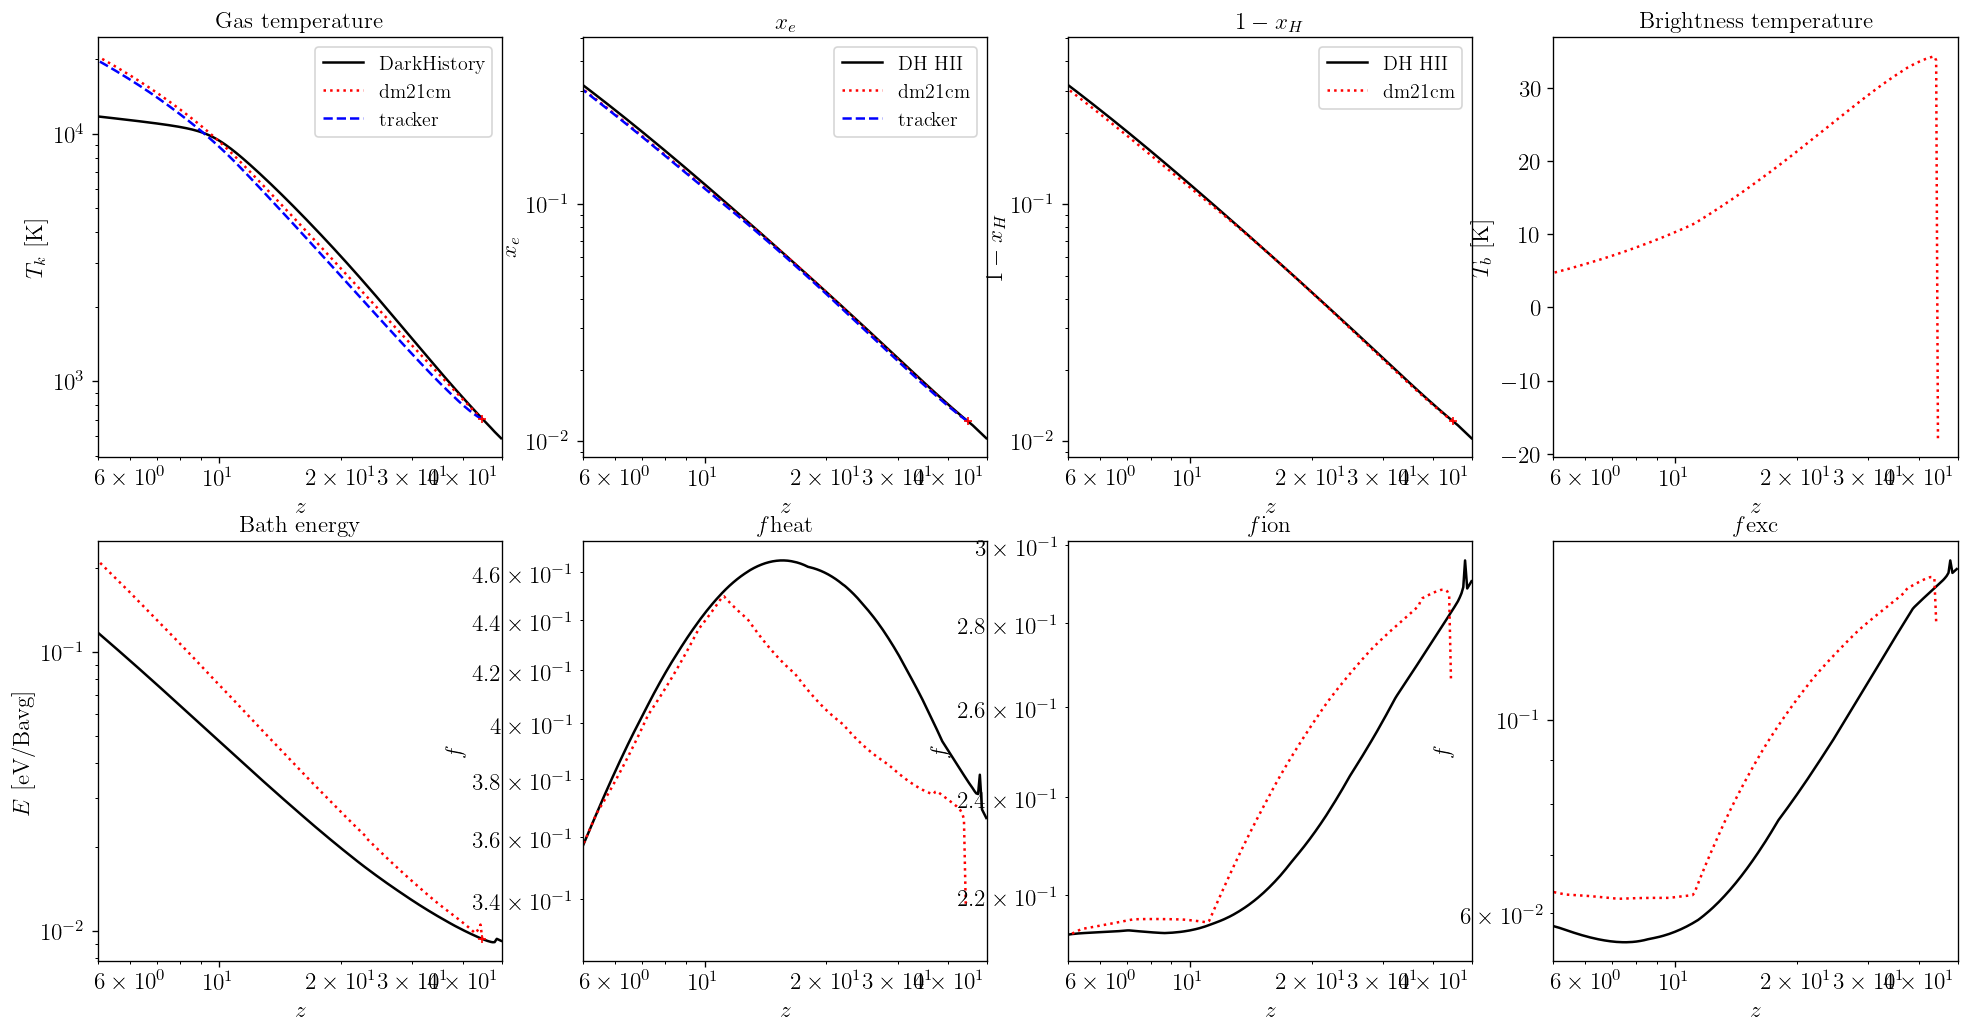

In [16]:
run_name = 'dhc_test'
dh_soln = pickle.load(open(f"run_info/{run_name}_dh_soln.p", 'rb'))
run_name = 'dhc_test'
soln = np.load(f"run_info/{run_name}_records.npy", allow_pickle=True).item()
plot_global(dh_soln, soln, tracker=True)

In [22]:
soln['dep_heat'].shape

(205,)

In [23]:
soln['dE_inj_per_Bavg_unclustered'].shape

(205,)

/tmp/ipykernel_213550/1417834685.py:7: RuntimeWarning: invalid value encountered in divide
  axs[1].plot(soln['z'], soln['dep_heat']/soln['dE_inj_per_Bavg_unclustered'], label='ratio')


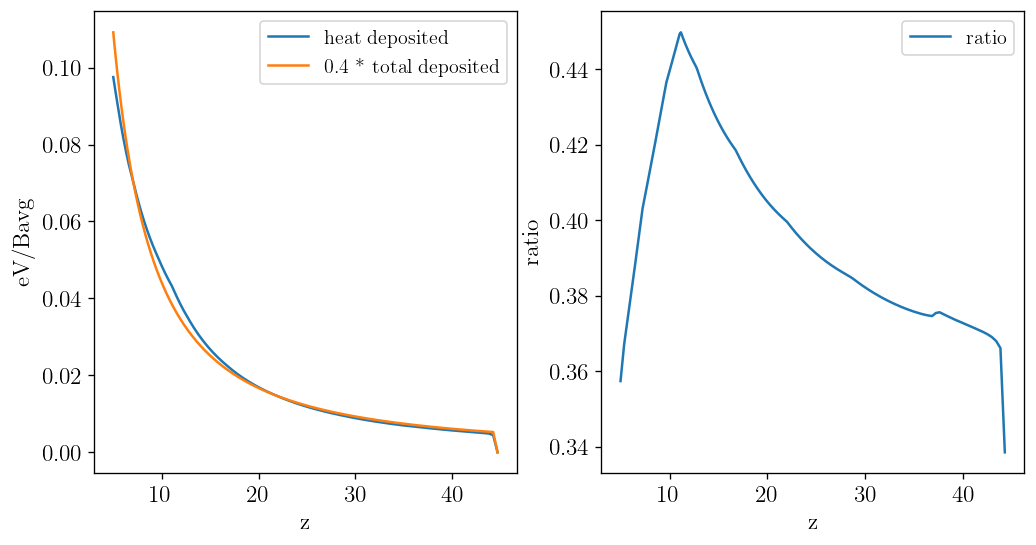

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(soln['z'], soln['dep_heat'], label='heat deposited')
axs[0].plot(soln['z'], soln['dE_inj_per_Bavg_unclustered']*0.4, label='0.4 * total deposited')
axs[0].set(xlabel='z', ylabel='eV/Bavg')
axs[0].legend()

axs[1].plot(soln['z'], soln['dep_heat']/soln['dE_inj_per_Bavg_unclustered'], label='ratio')
axs[1].set(xlabel='z', ylabel='ratio')
axs[1].legend()

In [28]:
a = soln['dep_heat']/soln['dE_inj_per_Bavg_unclustered']
a[0] = 0.
np.argmax(a)

/tmp/ipykernel_213550/4122091232.py:1: RuntimeWarning: invalid value encountered in divide
  a = soln['dep_heat']/soln['dE_inj_per_Bavg_unclustered']


133

In [35]:
for i in [132, 133, 134]:
    for k in ['z', 'T_s', 'T_b', 'T_k', 'x_e', '1-x_H', 'E_phot', 'dE_inj_per_B', 'dE_inj_per_Bavg_unclustered', 'dep_ion', 'dep_exc', 'dep_heat', 'T_k_tracker', 'x_e_tracker']:
        print(k, soln[k][i])
    print()

z 11.282595872600794
T_s 58.737865
T_b 11.606151
T_k 7688.562
x_e 0.099411
1-x_H 0.09941101
E_phot 0.06335019563417085
dE_inj_per_B 0.09350430429932999
dE_inj_per_Bavg_unclustered 0.09350430429932999
dep_ion 0.020181757655578284
dep_exc 0.005991031630803899
dep_heat 0.04196772096504163
T_k_tracker 7293.328701603561
x_e_tracker 0.09821310959432082

z 11.160986012476034
T_s 57.847366
T_b 11.447478
T_k 7828.679
x_e 0.100916475
1-x_H 0.10091643
E_phot 0.06441536961048507
dE_inj_per_B 0.09491019081764307
dE_inj_per_Bavg_unclustered 0.09491019081764307
dep_ion 0.020406047563275458
dep_exc 0.006002021324861566
dep_heat 0.042680650636800384
T_k_tracker 7428.432957442563
x_e_tracker 0.09970904947940913

z 11.04058021037231
T_s 57.060486
T_b 11.313902
T_k 7970.188
x_e 0.10244631
1-x_H 0.10244632
E_phot 0.06549776360940884
dE_inj_per_B 0.09633713826673329
dE_inj_per_Bavg_unclustered 0.09633713826673329
dep_ion 0.02068438744990823
dep_exc 0.00605868241655494
dep_heat 0.04328729132904607
T_k_tracke

In [30]:
soln['z'][132], soln['z'][133], soln['z'][134]

(11.282595872600794, 11.160986012476034, 11.04058021037231)

/tmp/ipykernel_213550/1695001224.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(soln['z'], soln['dep_heat']/soln['dE_inj_per_Bavg_unclustered'])


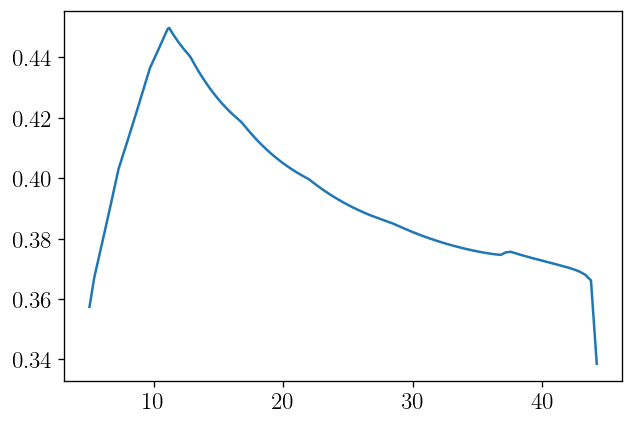

In [25]:
plt.plot(soln['z'], soln['dep_heat']/soln['dE_inj_per_Bavg_unclustered'])

In [ ]:
soln['dep_heat']/soln['dE_inj_per_Bavg_unclustered']

In [23]:
soln['z'][5]

42.4614921890888

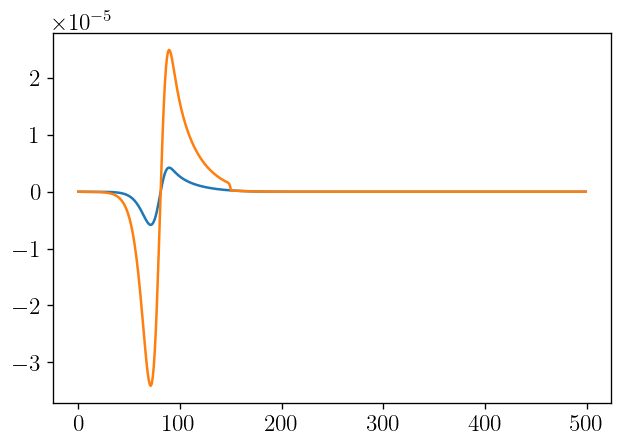

In [24]:
plt.plot(dh_bath_N_interp_func(soln['z'][5]))
plt.plot(soln['phot_N'][5])

In [31]:
from dm21cm.utils import load_h5_dict
abscs = load_h5_dict(f"../data/abscissas/abscs_zf01.h5")

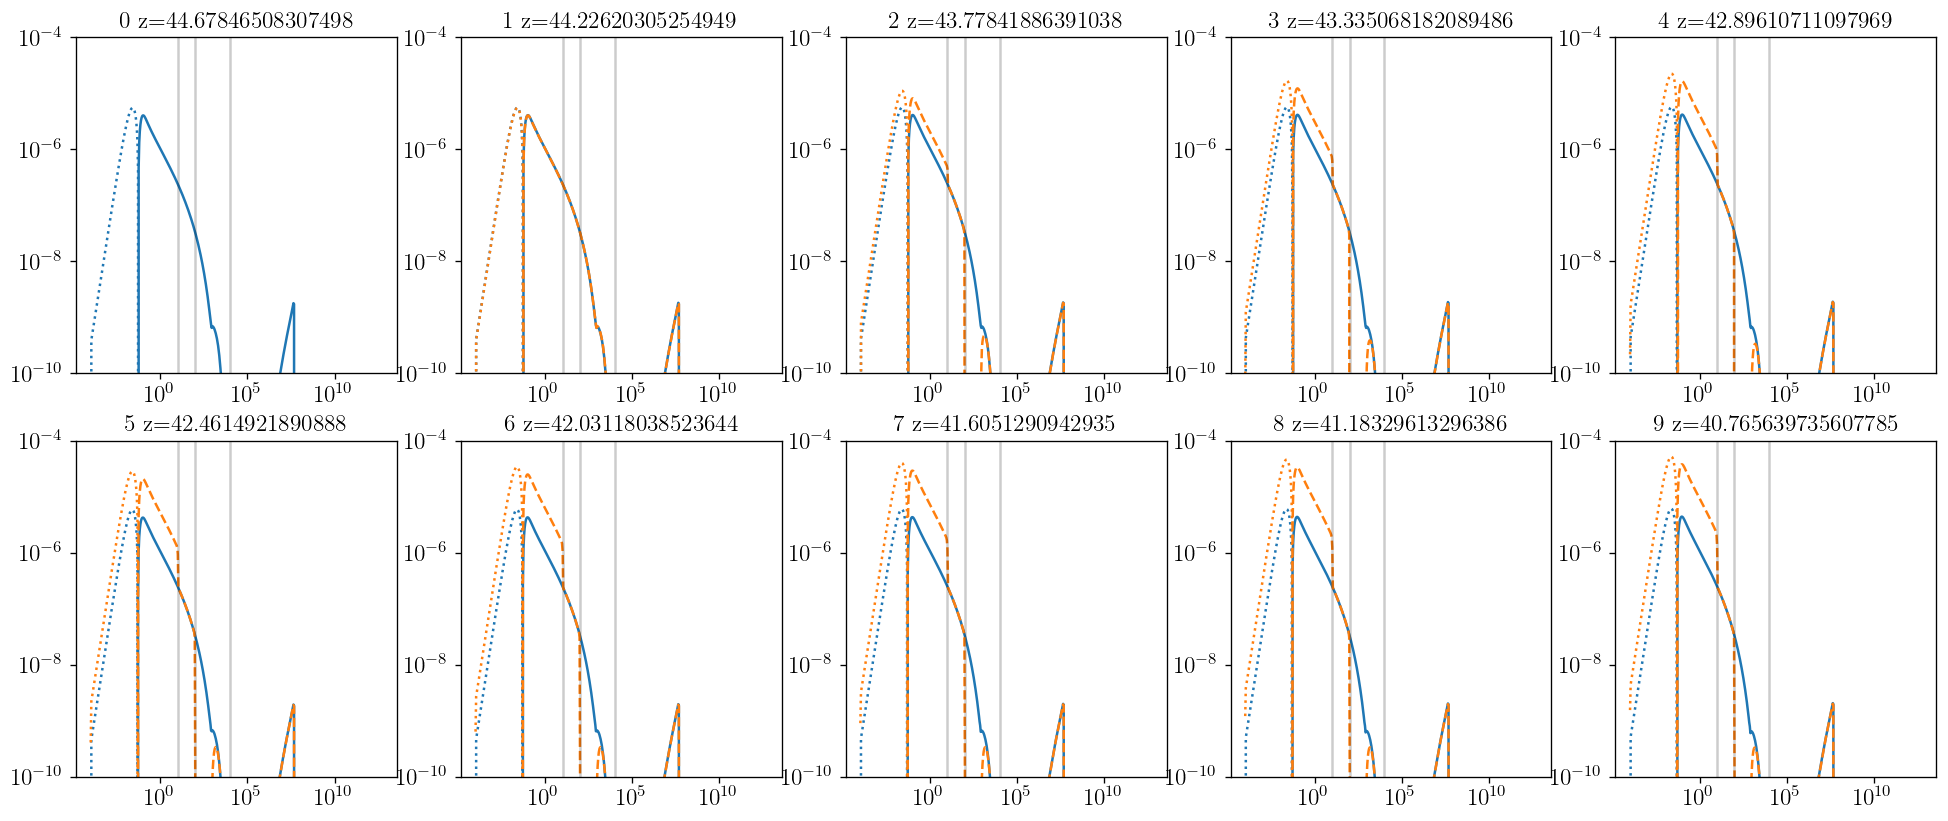

In [46]:
fig, axs = plt.subplots(2, 5, figsize=(20,8))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.plot(abscs['photE'], dh_bath_N_interp_func(soln['z'][i]), color='C0')
    ax.plot(abscs['photE'], -dh_bath_N_interp_func(soln['z'][i]), color='C0', ls=':')
    ax.plot(abscs['photE'], soln['injected_bath_N'][i], color='C1', ls='--')
    ax.plot(abscs['photE'], -soln['injected_bath_N'][i], color='C1', ls=':')
    #ax.axvline(0.1, color='k', ls='-', alpha=0.2)
    ax.axvline(10.2, color='k', ls='-', alpha=0.2)
    ax.axvline(1e2, color='k', ls='-', alpha=0.2)
    ax.axvline(1e4, color='k', ls='-', alpha=0.2)
    ax.set(xscale='log', yscale='log', ylim=(1e-10, 1e-4))
    ax.set(title=f"{i} z={soln['z'][i]}")

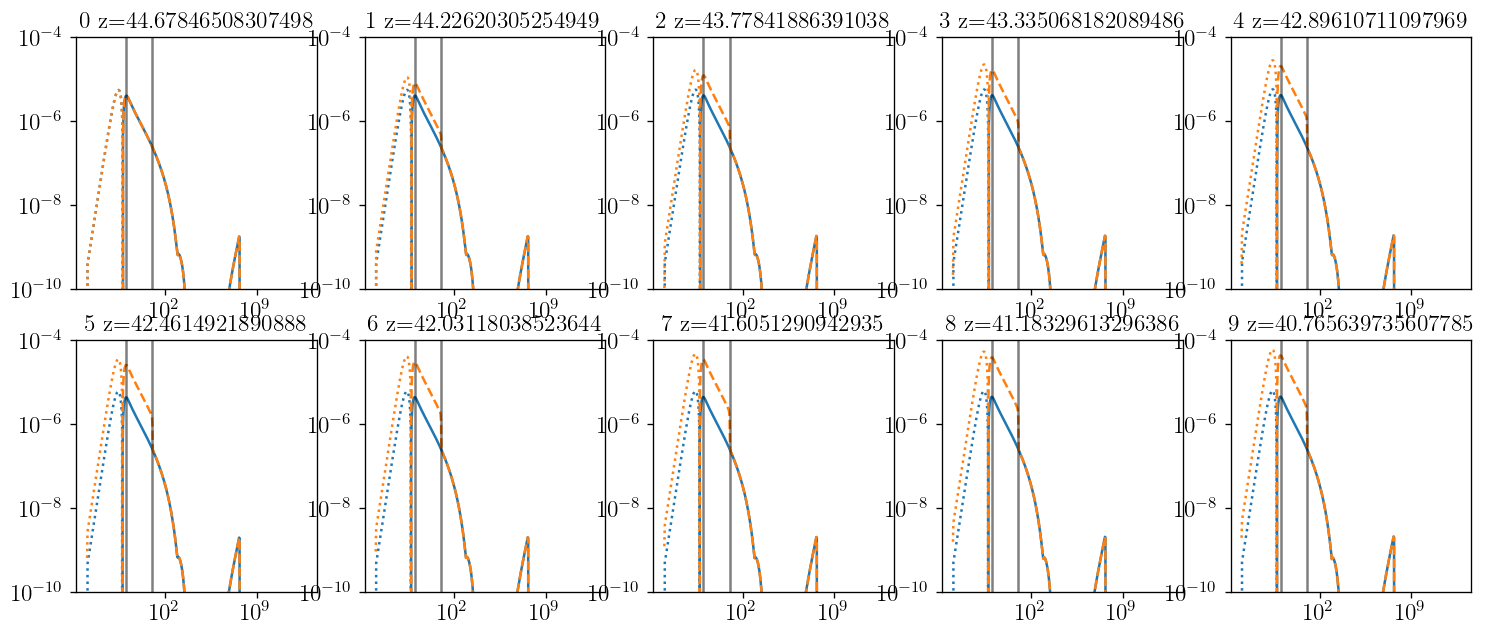

In [ ]:
# uniform xray flag is problematic
fig, axs = plt.subplots(2, 5, figsize=(15,6))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.plot(abscs['photE'], dh_bath_N_interp_func(soln['z'][i]), color='C0')
    ax.plot(abscs['photE'], -dh_bath_N_interp_func(soln['z'][i]), color='C0', ls=':')
    ax.plot(abscs['photE'], soln['phot_N'][i], color='C1', ls='--')
    ax.plot(abscs['photE'], -soln['phot_N'][i], color='C1', ls=':')
    ax.axvline(0.1, color='k', ls='-', alpha=0.5)
    ax.axvline(10, color='k', ls='-', alpha=0.5)
    ax.set(xscale='log', yscale='log', ylim=(1e-10, 1e-4))
    ax.set(title=f"{i} z={soln['z'][i]}")

In [118]:
phys.A_per_B

0.9999992500000001

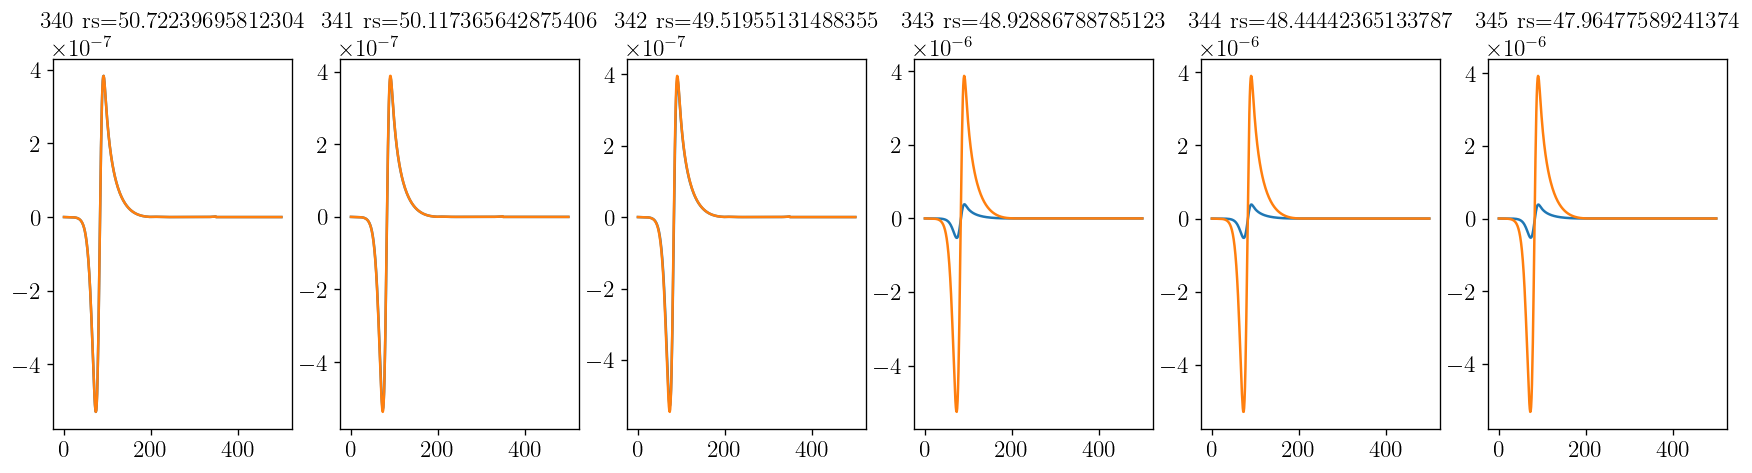

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(18,4))
for i in range(6):
    axs[i].plot(dh_soln['highengphot'][340].N)
    axs[i].plot(dh_soln['highengphot'][340+i].N)
    axs[i].set(title=f"{340+i} rs={dh_soln['rs'][340+i]}")

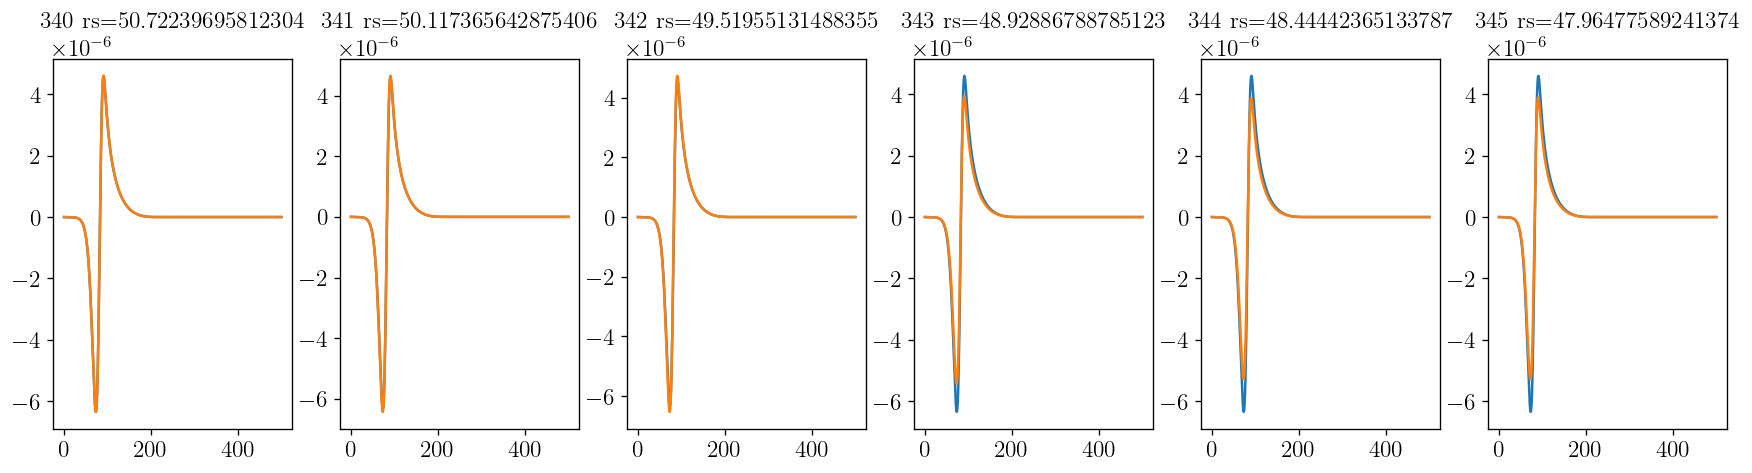

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(18,4))
for i in range(6):
    axs[i].plot(dh_soln['lowengphot'][340].N)
    axs[i].plot(dh_soln['lowengphot'][340+i].N)
    axs[i].set(title=f"{340+i} rs={dh_soln['rs'][340+i]}")

(45, 55)

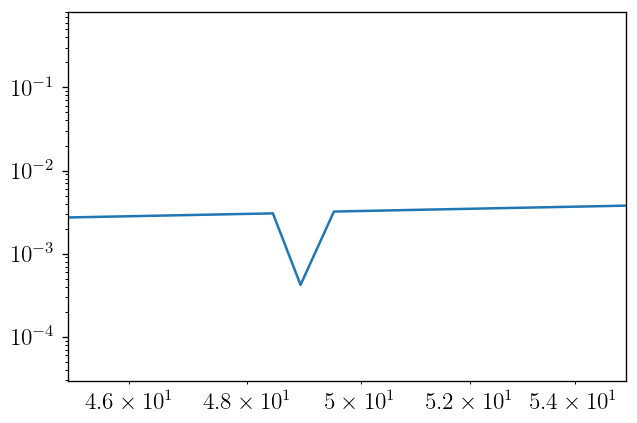

In [32]:
plt.plot(dh_soln['rs'], dh_soln['f']['low']['heat'])
plt.loglog()
plt.xlim(45, 55)

In [33]:
np.searchsorted(dh_soln['rs'][::-1], 45)

221

In [43]:
dh_soln['rs'][340:350]

array([50.72239696, 50.11736564, 49.51955131, 48.92886789, 48.44442365,
       47.96477589, 47.48987712, 47.01968032, 46.55413893, 46.09320686])

In [42]:
dh_soln['f']['low']['heat'][340:350]

array([0.00333702, 0.00327358, 0.00321077, 0.00042159, 0.0030538 ,
       0.00300836, 0.00296357, 0.00291929, 0.00287522, 0.00283162])

In [34]:
len(dh_soln['rs'])

573

In [23]:
from dm21cm.utils import load_h5_dict
abscs = load_h5_dict(f"../data/abscissas/abscs_{tf_version}.h5")

In [21]:
soln.keys()

dict_keys(['z', 'T_s', 'T_b', 'T_k', 'x_e', '1-x_H', 'E_phot', 'dE_inj_per_B', 'dE_inj_per_Bavg_unclustered', 'dep_ion', 'dep_exc', 'dep_heat', 'x_e_slice', 'x_H_slice'])

/tmp/ipykernel_1838978/3364818938.py:8: RuntimeWarning: invalid value encountered in divide
  interp_dm21 = interpolate.interp1d(soln['z'], soln[f'dep_{k}'] / soln[f'dE_inj_per_Bavg_unclustered'], bounds_error=False, fill_value=0.)


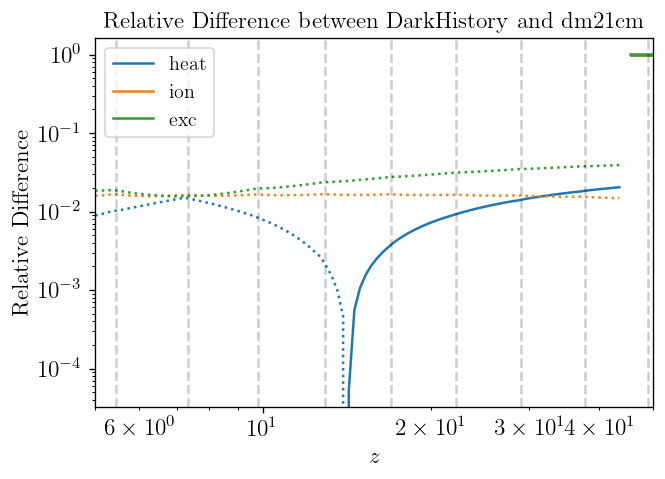

In [116]:
diffs = {}
for k in ['heat', 'ion', 'exc']:
    if k == 'ion':
        dh_fs = dh_soln['f']['low']['H ion'] + dh_soln['f']['high']['H ion'] + dh_soln['f']['low']['He ion'] + dh_soln['f']['high']['He ion']
    else:
        dh_fs = dh_soln['f']['low'][k] + dh_soln['f']['high'][k]
    interp_dh = interpolate.interp1d(dh_soln['rs'] - 1, dh_fs, bounds_error=False, fill_value=0.)
    interp_dm21 = interpolate.interp1d(soln['z'], soln[f'dep_{k}'] / soln[f'dE_inj_per_Bavg_unclustered'], bounds_error=False, fill_value=0.)

    common_x = np.geomspace(5, 50, 100)  # you can adjust the number of points
    common_dh = interp_dh(common_x)
    common_dm21 = interp_dm21(common_x)
    diffs.update({k : (common_dh - common_dm21) / common_dh})

fig, ax = plt.subplots()
for i, k in enumerate(diffs):
    ax.plot(common_x, diffs[k], label=k, color=f'C{i}')
    ax.plot(common_x, -diffs[k], ls=':', color=f'C{i}')
for rs in abscs['rs']:
    ax.axvline(rs-1, ls='--', color='k', alpha=0.2)
ax.set(xlim=(5, 50), xscale='log', yscale='log')  # adjust scales as needed
ax.set(xlabel='$z$', ylabel='Relative Difference', title='Relative Difference between DarkHistory and dm21cm')
ax.legend()

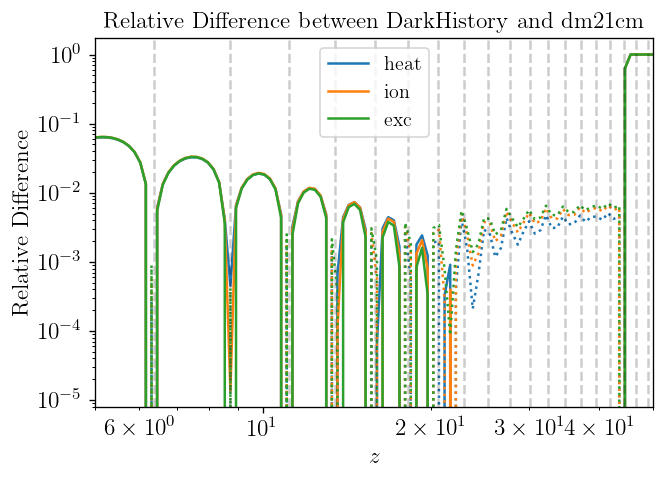

In [ ]:
diffs = {}
for k in ['heat', 'ion', 'exc']:
    if k == 'ion':
        dh_fs = dh_soln['f']['low']['H ion'] + dh_soln['f']['high']['H ion'] + dh_soln['f']['low']['He ion'] + dh_soln['f']['high']['He ion']
    else:
        dh_fs = dh_soln['f']['low'][k] + dh_soln['f']['high'][k]
    interp_dh = interpolate.interp1d(dh_soln['rs'] - 1, dh_fs, bounds_error=False, fill_value=0.)
    interp_dm21 = interpolate.interp1d(soln['z'], soln[f'f_{k}'], bounds_error=False, fill_value=0.)

    common_x = np.geomspace(5, 50, 100)  # you can adjust the number of points
    common_dh = interp_dh(common_x)
    common_dm21 = interp_dm21(common_x)
    diffs.update({k : (common_dh - common_dm21) / common_dh})

fig, ax = plt.subplots()
for i, k in enumerate(diffs):
    ax.plot(common_x, diffs[k], label=k, color=f'C{i}')
    ax.plot(common_x, -diffs[k], ls=':', color=f'C{i}')
for rs in abscs['rs']:
    ax.axvline(rs-1, ls='--', color='k', alpha=0.2)
ax.set(xlim=(5, 50), xscale='log', yscale='log')  # adjust scales as needed
ax.set(xlabel='$z$', ylabel='Relative Difference', title='Relative Difference between DarkHistory and dm21cm')
ax.legend()

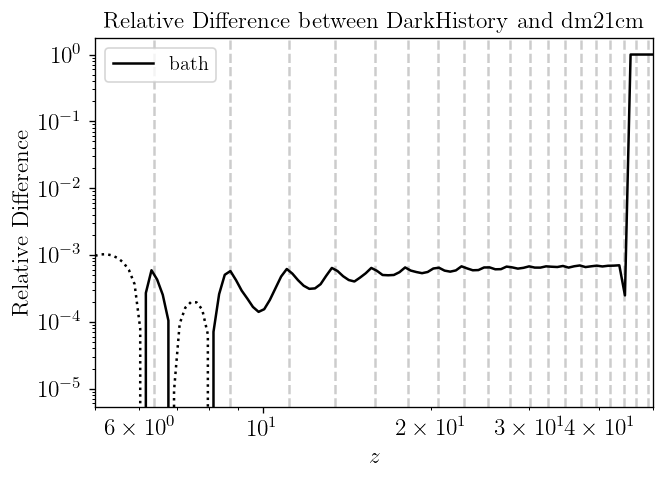

In [13]:
interp_dh = interpolate.interp1d(dh_soln['rs'] - 1, [s.toteng() for s in dh_soln['highengphot']], bounds_error=False, fill_value=0.)
interp_dm21 = interpolate.interp1d(soln['z'], soln['E_phot'], bounds_error=False, fill_value=0.)

common_x = np.geomspace(5, 50, 100)  # you can adjust the number of points
common_dh = interp_dh(common_x)
common_dm21 = interp_dm21(common_x)
diff = (common_dh - common_dm21) / common_dh

fig, ax = plt.subplots()
ax.plot(common_x, diff, label='bath', color=f'k')
ax.plot(common_x, -diff, ls=':', color=f'k')
for rs in abscs['rs']:
    ax.axvline(rs-1, ls='--', color='k', alpha=0.2)
ax.set(xlim=(5, 50), xscale='log', yscale='log')  # adjust scales as needed
ax.set(xlabel='$z$', ylabel='Relative Difference', title='Relative Difference between DarkHistory and dm21cm')
ax.legend()

In [18]:
dh_soln.keys()

dict_keys(['rs', 'x', 'Tm', 'highengphot', 'lowengphot', 'lowengelec', 'f'])

In [ ]:
zs = np.linspace(5.001, 44.999, 100)
dh_fs = dh_soln['f']['low']['heat'] + dh_soln['f']['high']['heat']
dh_arr = np.interp(1+zs, dh_soln['rs'][::-1], dh_fs[::-1])
p21c_arr = np.interp(zs, soln['z'][::-1], soln['f_heat'][::-1])
(np.abs(p21c_arr-dh_arr)/dh_arr)

In [ ]:
zs = np.linspace(5.001, 44.999, 100)
dh_bath_engs = [s.toteng() for s in dh_soln['highengphot']]
dh_arr = np.interp(1+zs, dh_soln['rs'][::-1], dh_bath_engs[::-1])
p21c_arr = np.interp(zs, soln['z'][::-1], soln['E_phot'][::-1])
np.max(np.abs(p21c_arr-dh_arr)/dh_arr)

0.05427165381579362

In [ ]:
plt.plot(zs, p21c_arr)
plt.plot(zs, dh_arr)